*By: B830459\
Date: 20/1/2023*

## Program Explanation: 

The program produces 2 outputs. Those include a table, that prints out the individual's weekly average attendance for each module and a bar chart that visualizes the table. 

In order for the above to be executed the user, must specify the fucntion **student_attendance( )** parameters.\
Those are a dictionary with all the modules names as keys and their formatted dataframe form from **neat_table( )** as values. Alongside the Student ID, which should be provided as a string type. 


In the case that an invalid Student ID is provided, the program will notify the user that such ID does not exist amongst the provided data. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from IPython.display import clear_output
from tkinter import *

## Database Imports

In [2]:
def import_from_db(df_name):
    """
    
    Imports SQL tables from CWDatabase.db
    in the form of pandas DataFrame.
    
    The function requries to be provided with:
    df_name -> the SQL table name as a 
    string type
    
    """
    conn = sqlite3.connect("CWDatabase.db")
    
    table_to_get = "SELECT * FROM " + df_name
    import_sql = pd.read_sql(table_to_get, conn)
    
    conn.close()
    
    return import_sql

## Extracing information from imported database tables

In [3]:
def neat_table(df, timetable):
    """
    
    Creates a dataframe, provided:
    
    df -> the students attendance SQL 
    table name as a string type
    timetable -> the modules timetable SQL 
    table name as a string type
    
    The newly created dataframe, sets the 
    "Timetable" type table from the 
    database and its respective values as 
    index for the "Records" table.
    Each individual students attendance 
    is represented under a column, 
    matching the respective multi index 
    for the specific class/lecture. 
    
    """

    # Modifying the student records table, to include a Session ID that will be used as "key"
    indexed = import_from_db(df).set_index("student_id")
    records = indexed.T
    empty = []
    for i in records.index:
        get_after = "Session_ID:_"
        result = i.split(get_after, 1)
        empty.append(int(result[1]))
    
    records["sess_id"] = empty
    
    # Importing the timetable 
    schedule = import_from_db(timetable)
    
    # Merging the updated records DF with the timetable DF
    complete_module = pd.merge(schedule, records, on = "sess_id")
    
    # Indexes that have to be set of the concated DF
    index = ["sem", "week", "sess_id", "date", "time", "type", "room"]
    
    # Setting the indexes 
    complete_module.set_index(index, inplace = True)
    
    # Fillining all Nans to 0
    complete_module = complete_module.fillna(0)
    
    return complete_module

## Extracting informations

In [4]:
def attendance_dict(func):
    """
    
    The function requries to be provided with:
    func -> a dictionary containing as its values, 
    DataFrames for the individual modules, being processed
    under the neat_table() function
    
    Modifies an existing dictionary such as import_modules()
    and makes it more  managable to use. 
    
    The modified dictionary output includes:
    key -> respective module(s) name
    values -> a dataframe including each individual 
              students weekly attendance, 
              expressed as a percentage rounded 
              to 2 d.p. for the "key" module. 
              
    """
    attendance_d = {}
    for i in func:
        attendance = ((func[i]).groupby("week").sum() \
                      /((func[i]).groupby("week").count()) * 100).round(2)
        attendance = attendance.reset_index()
        attendance_d[i] = attendance
        
    return attendance_d

## Styling of end output

In [5]:
def sort_weeks_in_df(df):
    """    
    
    Neats a provided dataframe, by sorting out 
    the week's indexes in a ascending order, 
    in the scenario that a week's 
    number includes 2 or more digits. 
    
    """ 
    
    ordered_weeks = []
    for i in df.index:
        ordered_weeks.append(int(i[1:]))
    
    df["week_number"] = ordered_weeks
    df = df.sort_values("week_number")
    df.drop("week_number", inplace = True, axis = 1)
    
    return df

## Main

In [6]:
def student_attendance(func, user_input):
    """

    The function requries to be provided with:
    func -> a dictionary containing as its values, 
    dataframes for the individual modules, being processed
    under the neat_table( ) function
    user_input -> Student ID as a string type
    
    The function returns:
    1. Dataframe with the Student's weekly attendance 
    for all modules present in the dictionary.
    2. A bar chart based on the dataframe above.
    
    """
    
    # Merges the dataframes from the dictionary sideways
    df_modules = pd.concat(attendance_dict(func), axis = 1)
    df_modules = df_modules.fillna(0)
    
    # Creates a list with all the Student IDs
    student_id = []
    for i in range(len(df_modules.columns)):
        x = str(df_modules.columns[i][1])
        if x not in student_id:  
            student_id.append(x)
            
    # Checks whether the user provided Student ID does actually exist        
    while True:
        if user_input in student_id: 
            break
        else:
            print("Does not seem to find a student with Student ID: " + user_input + " in the record list")
            print("Try again")
            return
    
    # Creates a list, where each list item is the weekly attendance for each module
    weekly_avg_attendance = []
    for i in attendance_dict(func).keys():
        x = df_modules[i].groupby("week").sum().loc[:, int(user_input)]
        weekly_avg_attendance.append(x)
        
    student_df = pd.DataFrame(weekly_avg_attendance).T.loc["W1":]
    
    # Sort the weeks index
    student_df = sort_weeks_in_df(student_df)

    # Create a list, where each item is the module name with a % sign at the end
    col_labels = []
    for i in attendance_dict(func).keys():
        name = i.upper() + " %"
        col_labels.append(name)
        
    student_df.columns = col_labels
    student_df = student_df.rename_axis("Week No", axis = 0)
    
    # Display DataFrame
    print("The attendance record of Student ID " + str(user_input) + " :")
    display(student_df)

    # Graph DataFrame
    student_df.plot(kind = "bar")
    
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.xticks(rotation = 0)
    plt.xlabel("Week No")
    plt.ylabel("Attendance %")
    
    plt.show()

## Testing

In [7]:
def import_modules():
    """
    
    The function intiliazes all of the modules information 
    into "neat" dataframes, by making use of the 
    neat_table( ) function.
    
    The function is used predomentatly as a 
    dictionary to access multiple modules 
    attendances. 
    
    """
    
    coa111 = neat_table("dfcoa111", "sesscoa111")
    coa122 = neat_table("dfcoa122", "sesscoa122")
    
    return locals()

In [8]:
neat_table("dfcoa122", "sesscoa122")

0    \
sem week sess_id date                  time          type          room           
S1  W1   0       Monday (03-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         1       Thursday (06-10-2022) 09:00 - 11:00 Computer Lab  N001...  1.0   
         2       Thursday (06-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
    W2   3       Monday (10-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         4       Thursday (13-10-2022) 09:00 - 11:00 Computer Lab  N001...  0.0   
         5       Thursday (13-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
    W3   6       Monday (17-10-2022)   14:00 - 16:00 Lecture       CC012    0.0   
         7       Thursday (20-10-2022) 09:00 - 11:00 Computer Lab  N001...  0.0   
         8       Thursday (20-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
    W4   9       Monday (24-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         10      Thursday (27-10-2022) 09:00 - 11:00 Computer Lab  N001...  0.0   
         11      Thursday (27-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
         12      Friday (28-10-2022)   12:00 - 13:00 Personal Best CC011    0.0   
    W5   13      Monday (31-10-2022)   14:00 - 16:00 Lecture       CC012    0.0   
         16      Thursday (03-11-2022) 09:00 - 11:00 Test          N001...  1.0   
         17      Thursday (03-11-2022) 11:00 - 13:00 Test          N001...  0.0   
    W6   18      Monday (07-11-2022)   14:00 - 16:00 Lecture       CC012    0.0   

                                                                            1    \
sem week sess_id date                  time          type          room           
S1  W1   0       Monday (03-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         1       Thursday (06-10-2022) 09:00 - 11:00 Computer Lab  N001...  1.0   
         2       Thursday (06-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
    W2   3       Monday (10-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         4       Thursday (13-10-2022) 09:00 - 11:00 Computer Lab  N001...  1.0   
         5       Thursday (13-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
    W3   6       Monday (17-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         7       Thursday (20-10-2022) 09:00 - 11:00 Computer Lab  N001...  1.0   
         8       Thursday (20-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
    W4   9       Monday (24-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         10      Thursday (27-10-2022) 09:00 - 11:00 Computer Lab  N001...  1.0   
         11      Thursday (27-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
         12      Friday (28-10-2022)   12:00 - 13:00 Personal Best CC011    1.0   
    W5   13      Monday (31-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         16      Thursday (03-11-2022) 09:00 - 11:00 Test          N001...  1.0   
         17      Thursday (03-11-2022) 11:00 - 13:00 Test          N001...  0.0   
    W6   18      Monday (07-11-2022)   14:00 - 16:00 Lecture       CC012    1.0   

                                                                            2    \
sem week sess_id date                  time          type          room           
S1  W1   0       Monday (03-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         1       Thursday (06-10-2022) 09:00 - 11:00 Computer Lab  N001...  1.0   
         2       Thursday (06-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
    W2   3       Monday (10-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         4       Thursday (13-10-2022) 09:00 - 11:00 Computer Lab  N001...  1.0   
         5       Thursday (13-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
    W3   6       Monday (17-10-2022)   14:00 - 16:00 Lecture       CC012    1.0   
         7       Thursday (20-10-2022) 09:00 - 11:00 Computer Lab  N001...  1.0   
         8       Thursday (20-10-2022) 11:00 - 13:00 Computer Lab  N001...  0.0   
    W4 

In [9]:
attendance_dict(import_modules())["coa122"]

,week,0,1,2,3,4,5,6,7,8,...,233,234,235,236,237,238,239,240,241,242
0,W1,66.67,66.67,66.67,0.00,66.67,66.67,66.67,66.67,66.67,...,66.67,66.67,66.67,33.33,33.33,0.00,66.67,66.67,66.67,0.0
1,W2,33.33,66.67,66.67,0.00,33.33,66.67,33.33,66.67,33.33,...,66.67,66.67,66.67,66.67,66.67,66.67,66.67,66.67,66.67,0.0
2,W3,0.00,66.67,66.67,33.33,33.33,66.67,33.33,66.67,33.33,...,66.67,66.67,33.33,66.67,66.67,66.67,33.33,66.67,66.67,0.0
3,W4,25.00,75.00,25.00,50.00,25.00,75.00,25.00,50.00,75.00,...,75.00,75.00,25.00,50.00,75.00,50.00,50.00,75.00,75.00,0.0
4,W5,33.33,66.67,33.33,66.67,33.33,33.33,66.67,33.33,33.33,...,33.33,33.33,33.33,0.00,33.33,66.67,66.67,66.67,33.33,0.0
5,W6,0.00,100.00,100.00,100.00,100.00,100.00,100.00,0.00,0.00,...,100.00,100.00,100.00,100.00,100.00,100.00,0.00,100.00,100.00,0.0


In [10]:
student_attendance(import_modules(), "142")

Does not seem to find a student with Student ID: 142 in the record list
Try again


The attendance record of Student ID 145 :


,COA111 %,COA122 %
Week No,,
W1,50.0,33.33
W2,100.0,66.67
W3,100.0,33.33
W4,100.0,75.00
W5,50.0,66.67
W6,NaN,100.00


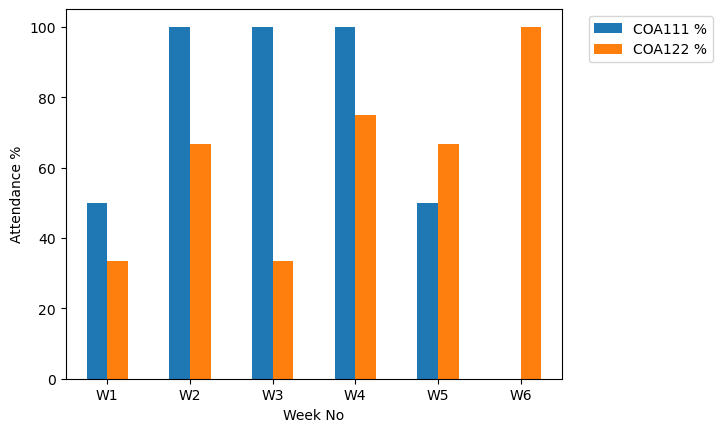

In [11]:
student_attendance(import_modules(), "145")